## NEW YEAR DATA Battle от Codenrock

Ваша задача настроить алгоритмы распознавания, так, чтобы с большей
вероятностью определять наличие Деда Мороза на фото. Ссылка на [датасет](https://drive.google.com/file/d/1pUqUTr109MN-ChG87XoMnPaojXIQm7bm/view?usp=sharing) и [csv_file](https://drive.google.com/file/d/1Ad1ehTYmu-XtyzFStHWD6X9kYcJamFjC/view?usp=sharing). 

In [10]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
import numpy as np
import time 

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
!pip install pyunpack
import pandas as pd
import numpy as np

from pyunpack import Archive
Archive('/content/gdrive/MyDrive/santa/train.zip').extractall('/content/')


Введем функцию для отображения изображений, на которых была допущена ошибка

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(8, 6))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)



В качестве базовой модели для обучения возьмем предобученную mobilenet_v3_small предобученную на ImageNet, которая обладает довольно хорошей точностью при низкой вычислительной сложности. В нашей задаче есть три варианта ответа: Дед Мороз, Санта Клаус и просто бородатый мужчина. Изменим финальный слой, чтобы классфикатор давал нам нужное количество ответов.

In [14]:
def init_model(device, unfreeze_lay = None, value = False):
    model = torchvision.models.mobilenet_v3_small(pretrained=True)
    set_requires_grad(model, unfreeze_lay, value)
    model.classifier[3] = torch.nn.Linear(model.classifier[0].out_features, 3)
    model = model.to(device)
    return model

Создадим загрузчик данных (DedyDataset) для наших фотографий, а так же класс для трансформации датасетов наших изображений.

In [5]:
class DedyDataset(Dataset):
    def __init__(self, root_dir, csv_path=None, transform=None):
        
        self.files = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)]
        self.targets = None
        if csv_path:
            df = pd.read_csv(csv_path, sep="\t")
            self.targets = df["class_id"].tolist()
            self.files = [os.path.join(root_dir, fname) for fname in df["image_name"].tolist()]

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        image = Image.open(self.files[idx])
        target = self.targets[idx] if self.targets else -1
        return image, target

In [15]:
class WrapperDataset:
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return image, label

    def __len__(self):
        return len(self.dataset)

Определим путь к папкам содержащим наши данные, и куда будем сохранять веса нашей модели.

In [16]:
MODEL_WEIGHTS = "/content/gdrive/MyDrive/santa/weight/weight.pt"
TRAIN_DATASET = "/content/train"
TRAIN_CSV = "/content/gdrive/MyDrive/santa/train.csv"

Опишем функцию обучения нашей модели, пока мы будем обучать  без заморозки слоев, но пропишем в функции возможность дальнейшего изменения параметра. Так же в процессе будем сохранять модели, с лучшим  скором.

In [17]:
def set_requires_grad(model, freeze_lay = None, value=False):
  if not freeze_lay:
    for param in model.parameters():
        param.requires_grad = value
  else:
    for param in model.features[freeze_lay:].parameters():
        param.requires_grad = False


def train_model(model, dataloaders, criterion, optimizer, scheduler,
                phases, num_epochs=3, show_image = True):
    start_time = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    acc_history = {k: list() for k in phases}
    loss_history = {k: list() for k in phases}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        j = 0
        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = len(dataloaders[phase])
            for inputs, labels in tqdm(dataloaders[phase], total=n_batches):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    if (phase == 'val')&(epoch == num_epochs - 1) & (show_image): 
                      for i in range(len(preds)):
                        if preds[i] != labels.data[i]:
                          imshow(inputs.data[i,:,:,:].to('cpu'))
                        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double()
            epoch_acc /= len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,
                                                       epoch_acc))
            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc)
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        print()

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                        time_elapsed % 60))
    torch.save(best_model_wts, MODEL_WEIGHTS)
    model.load_state_dict(best_model_wts)
    return model, acc_history, loss_history

Приступаем к обучению модели, перед этим определим различные трансформации изображения на тренировочном и валидационном датасете. 

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 0/4
----------


100%|██████████| 64/64 [00:23<00:00,  2.73it/s]


train Loss: 0.5529 Acc: 0.8223


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


val Loss: 0.3392 Acc: 0.8672

Epoch 1/4
----------


100%|██████████| 64/64 [00:17<00:00,  3.73it/s]


train Loss: 0.2972 Acc: 0.9033


100%|██████████| 16/16 [00:04<00:00,  3.89it/s]


val Loss: 0.2678 Acc: 0.8906

Epoch 2/4
----------


100%|██████████| 64/64 [00:15<00:00,  4.20it/s]


train Loss: 0.2607 Acc: 0.9180


100%|██████████| 16/16 [00:03<00:00,  4.18it/s]


val Loss: 0.2378 Acc: 0.9219

Epoch 3/4
----------


100%|██████████| 64/64 [00:15<00:00,  4.17it/s]


train Loss: 0.2171 Acc: 0.9268


100%|██████████| 16/16 [00:03<00:00,  4.05it/s]


val Loss: 0.2224 Acc: 0.9258

Epoch 4/4
----------


100%|██████████| 64/64 [00:15<00:00,  4.15it/s]


train Loss: 0.2037 Acc: 0.9414


100%|██████████| 16/16 [00:03<00:00,  4.11it/s]


val Loss: 0.2169 Acc: 0.9258

Training complete in 1m 50s
Epoch 0/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.09it/s]


train Loss: 0.1827 Acc: 0.9453


100%|██████████| 16/16 [00:03<00:00,  4.12it/s]


val Loss: 0.2150 Acc: 0.9258

Epoch 1/24
----------


100%|██████████| 64/64 [00:23<00:00,  2.73it/s]


train Loss: 0.1817 Acc: 0.9424


100%|██████████| 16/16 [00:03<00:00,  4.14it/s]


val Loss: 0.2139 Acc: 0.9258

Epoch 2/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.12it/s]


train Loss: 0.1951 Acc: 0.9385


100%|██████████| 16/16 [00:03<00:00,  4.17it/s]


val Loss: 0.2120 Acc: 0.9297

Epoch 3/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.20it/s]


train Loss: 0.2011 Acc: 0.9268


100%|██████████| 16/16 [00:03<00:00,  4.14it/s]


val Loss: 0.2112 Acc: 0.9297

Epoch 4/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.22it/s]


train Loss: 0.1710 Acc: 0.9482


100%|██████████| 16/16 [00:03<00:00,  4.19it/s]


val Loss: 0.2097 Acc: 0.9258

Epoch 5/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.22it/s]


train Loss: 0.1890 Acc: 0.9326


100%|██████████| 16/16 [00:04<00:00,  3.95it/s]


val Loss: 0.2096 Acc: 0.9258

Epoch 6/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.01it/s]


train Loss: 0.1987 Acc: 0.9336


100%|██████████| 16/16 [00:03<00:00,  4.17it/s]


val Loss: 0.2095 Acc: 0.9258

Epoch 7/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.22it/s]


train Loss: 0.1830 Acc: 0.9414


100%|██████████| 16/16 [00:03<00:00,  4.18it/s]


val Loss: 0.2087 Acc: 0.9297

Epoch 8/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.22it/s]


train Loss: 0.1798 Acc: 0.9385


100%|██████████| 16/16 [00:03<00:00,  4.13it/s]


val Loss: 0.2088 Acc: 0.9258

Epoch 9/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.19it/s]


train Loss: 0.1956 Acc: 0.9395


100%|██████████| 16/16 [00:03<00:00,  4.17it/s]


val Loss: 0.2094 Acc: 0.9258

Epoch 10/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.22it/s]


train Loss: 0.1772 Acc: 0.9453


100%|██████████| 16/16 [00:03<00:00,  4.13it/s]


val Loss: 0.2088 Acc: 0.9258

Epoch 11/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.24it/s]


train Loss: 0.1911 Acc: 0.9395


100%|██████████| 16/16 [00:03<00:00,  4.15it/s]


val Loss: 0.2083 Acc: 0.9258

Epoch 12/24
----------


100%|██████████| 64/64 [00:16<00:00,  3.93it/s]


train Loss: 0.1894 Acc: 0.9355


100%|██████████| 16/16 [00:03<00:00,  4.14it/s]


val Loss: 0.2082 Acc: 0.9258

Epoch 13/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.04it/s]


train Loss: 0.1788 Acc: 0.9414


100%|██████████| 16/16 [00:03<00:00,  4.18it/s]


val Loss: 0.2083 Acc: 0.9258

Epoch 14/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.23it/s]


train Loss: 0.1746 Acc: 0.9473


100%|██████████| 16/16 [00:03<00:00,  4.17it/s]


val Loss: 0.2086 Acc: 0.9258

Epoch 15/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.22it/s]


train Loss: 0.1745 Acc: 0.9492


100%|██████████| 16/16 [00:03<00:00,  4.15it/s]


val Loss: 0.2090 Acc: 0.9258

Epoch 16/24
----------


100%|██████████| 64/64 [00:16<00:00,  3.86it/s]


train Loss: 0.1683 Acc: 0.9434


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


val Loss: 0.2080 Acc: 0.9297

Epoch 17/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.23it/s]


train Loss: 0.1785 Acc: 0.9551


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


val Loss: 0.2081 Acc: 0.9297

Epoch 18/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.25it/s]


train Loss: 0.1777 Acc: 0.9521


100%|██████████| 16/16 [00:03<00:00,  4.12it/s]


val Loss: 0.2089 Acc: 0.9297

Epoch 19/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.25it/s]


train Loss: 0.1790 Acc: 0.9482


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


val Loss: 0.2085 Acc: 0.9297

Epoch 20/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


train Loss: 0.1981 Acc: 0.9316


100%|██████████| 16/16 [00:03<00:00,  4.27it/s]


val Loss: 0.2084 Acc: 0.9258

Epoch 21/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.28it/s]


train Loss: 0.1841 Acc: 0.9414


100%|██████████| 16/16 [00:03<00:00,  4.15it/s]


val Loss: 0.2083 Acc: 0.9258

Epoch 22/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.26it/s]


train Loss: 0.1747 Acc: 0.9365


100%|██████████| 16/16 [00:03<00:00,  4.21it/s]


val Loss: 0.2086 Acc: 0.9258

Epoch 23/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.29it/s]


train Loss: 0.1873 Acc: 0.9404


100%|██████████| 16/16 [00:03<00:00,  4.20it/s]


val Loss: 0.2087 Acc: 0.9258

Epoch 24/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.28it/s]


train Loss: 0.1736 Acc: 0.9463


  6%|▋         | 1/16 [00:00<00:08,  1.69it/s]

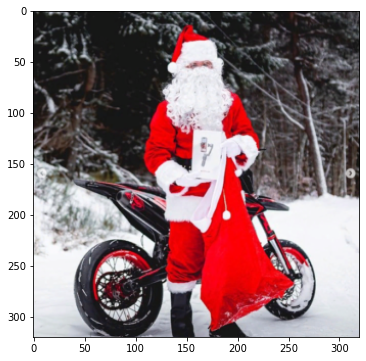

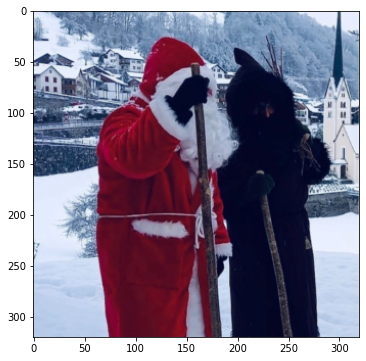

 12%|█▎        | 2/16 [00:01<00:14,  1.06s/it]

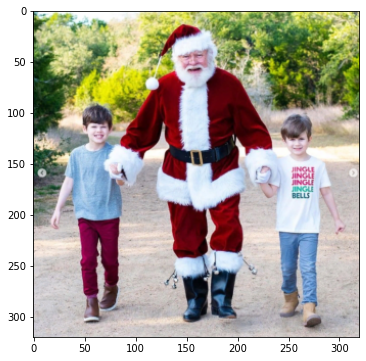

 19%|█▉        | 3/16 [00:02<00:10,  1.25it/s]

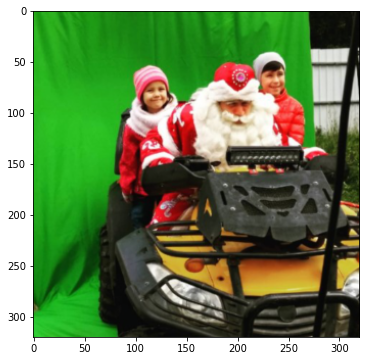

 31%|███▏      | 5/16 [00:03<00:06,  1.79it/s]

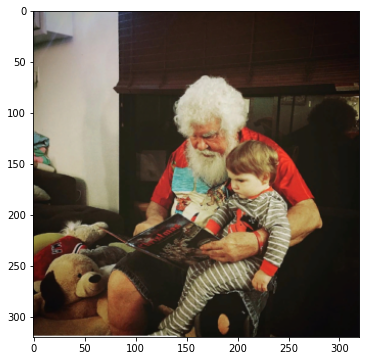

 38%|███▊      | 6/16 [00:03<00:05,  1.83it/s]

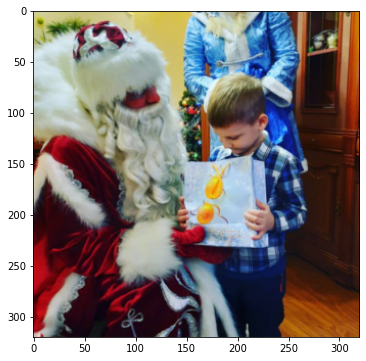

 44%|████▍     | 7/16 [00:04<00:04,  1.89it/s]

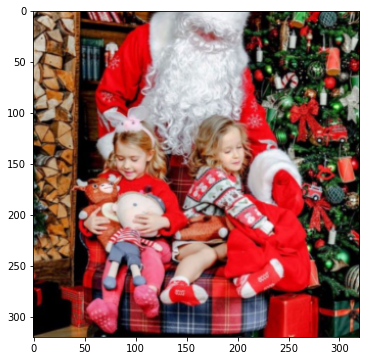

 50%|█████     | 8/16 [00:04<00:04,  1.87it/s]

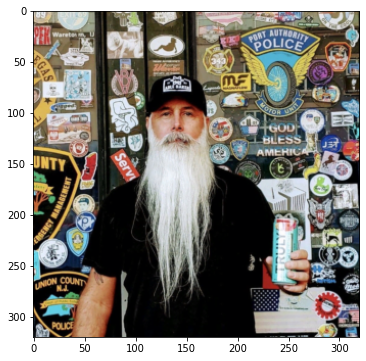

 56%|█████▋    | 9/16 [00:05<00:03,  1.89it/s]

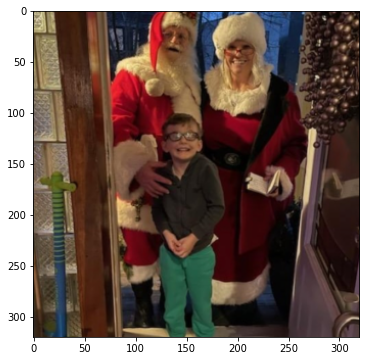

 62%|██████▎   | 10/16 [00:05<00:03,  1.79it/s]

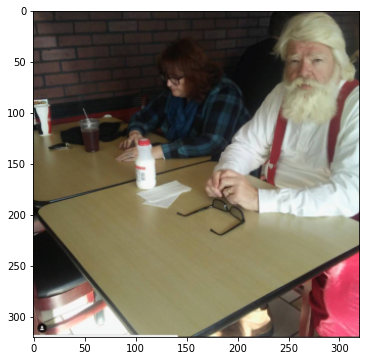

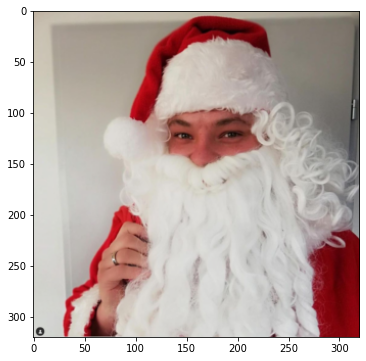

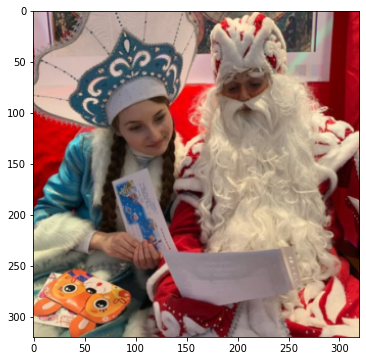

 75%|███████▌  | 12/16 [00:07<00:02,  1.62it/s]

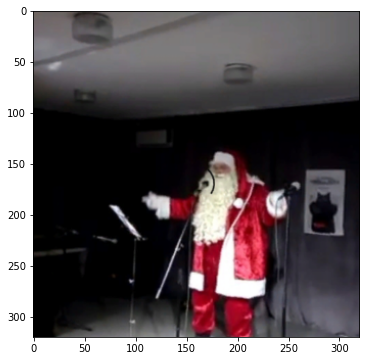

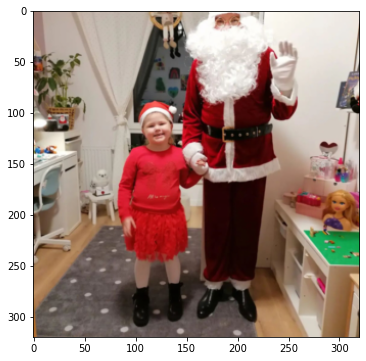

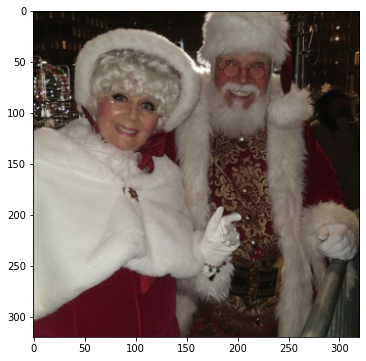

 81%|████████▏ | 13/16 [00:08<00:02,  1.39it/s]

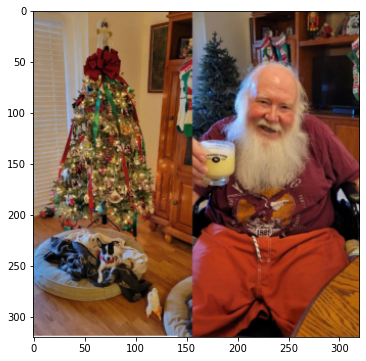

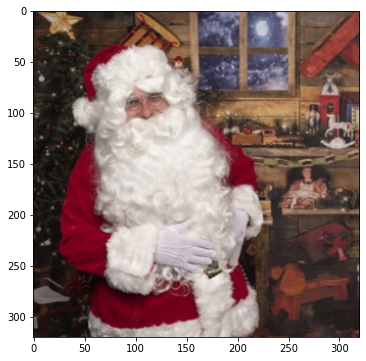

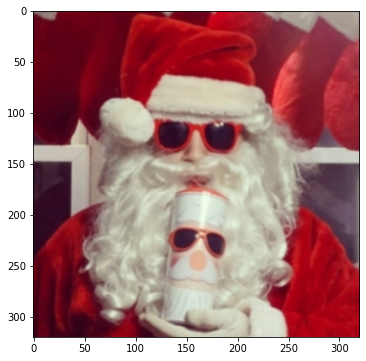

 94%|█████████▍| 15/16 [00:09<00:00,  1.49it/s]

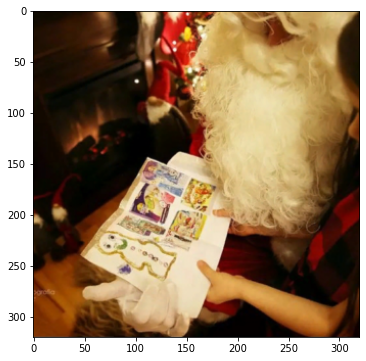

100%|██████████| 16/16 [00:10<00:00,  1.60it/s]


val Loss: 0.2087 Acc: 0.9258

Training complete in 8m 17s


In [18]:
trans =  {
    'train': transforms.Compose([
        transforms.Resize((320)),
        transforms.CenterCrop(320),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=25, translate=(0, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(320),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}
dset = DedyDataset(TRAIN_DATASET, TRAIN_CSV)
labels = dset.targets
indices = list(range(len(labels)))
ind_train, ind_test, _, _ = train_test_split(indices, labels, test_size=0.2, random_state=139, stratify=labels)
trainset = torch.utils.data.Subset(dset, ind_train)                           
testset = torch.utils.data.Subset(dset, ind_test)
batch_size = 16
num_workers = 2
trainloader = torch.utils.data.DataLoader(WrapperDataset(trainset, transform=trans['train']),batch_size=batch_size,
                                        shuffle=True, num_workers=num_workers)

testloader = torch.utils.data.DataLoader(WrapperDataset(testset, transform=trans['val']), batch_size=batch_size,
                                        shuffle=False, num_workers=num_workers)
loaders = {'train': trainloader, 'val': testloader}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = init_model(device)
pretrain_optimizer = torch.optim.Adam(model.classifier[3].parameters(),
                                lr=0.001)
train_optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
exp_lr_scheduler1 = lr_scheduler.StepLR(pretrain_optimizer, step_size=7, gamma=0.1)
exp_lr_scheduler2 = lr_scheduler.StepLR(train_optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

# Pretrain
# запустить предобучение модели на две эпохи
pretrain_results = train_model(model, loaders, criterion, pretrain_optimizer,exp_lr_scheduler1,phases=['train', 'val'], num_epochs=5, show_image=False)

# Train
# запустить дообучение модели
set_requires_grad(model, True)
train_results = train_model(pretrain_results[0], loaders, criterion, train_optimizer,exp_lr_scheduler2,phases=['train', 'val'], num_epochs=25, show_image=True )


Так как у нас небольшое количество данных (изображений), оценивать точность модели будем по всему корпусу размеченных фотографий. Загружаем нашу лучшую модель, делаем предобработку изображений и считаем точность наших предсказаний.

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



trans2 = transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(320),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
batch_size = 16
num_workers = 2
dset = DedyDataset(TRAIN_DATASET, TRAIN_CSV, trans2)
testloader = torch.utils.data.DataLoader(WrapperDataset(dset, transform=trans['val']), batch_size=batch_size,
                                        shuffle=False, num_workers=num_workers)

def evaluate(model, dataloaders):
    model.eval()
    data_size = 0
    runninig_correct = 0
    for data in dataloaders:
        # получаем картинки и метки
        inputs, labels = data
        data_size += len(labels)
        # переносим на gpu, если возможно
        if True:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / data_size
    
best_model = init_model(device)
best_model.load_state_dict(torch.load(MODEL_WEIGHTS))
score = evaluate(best_model, testloader)
print(score)

0.95390625


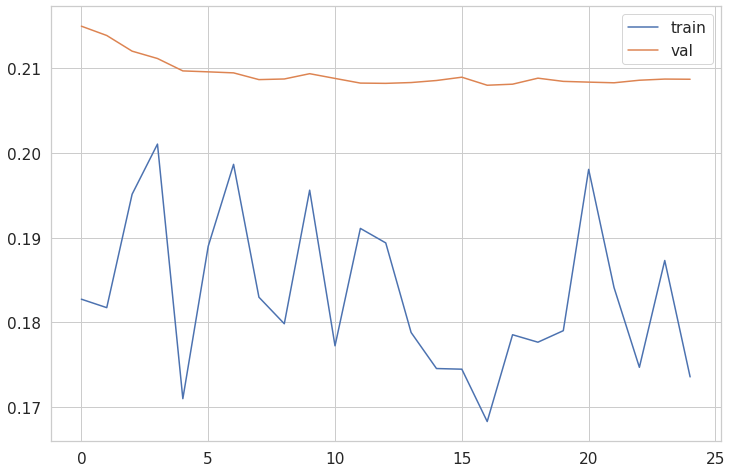

In [20]:
import seaborn as sns
losses = train_results[2]
sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

Мы видим, что модель начинает переобучаться и точность на валидационной выборке падает.

##Finetunning model

Так как мы используем уже предобученную на большем корпусе изображений модель, поэтому заморозим первые слои нашей модели при обучении, так как считаем что наша модель уже отлично умеет определять низкоуровневые признаки, и обучим только последние слои.



In [21]:
layers_to_unfreeze = 6
model_mixed = init_model(device, layers_to_unfreeze)

train_optimizer = torch.optim.Adam(list(model_mixed.features.parameters())[:-layers_to_unfreeze] + 
                      list(model_mixed.classifier.parameters()), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(train_optimizer, step_size=4, gamma=0.3)

criterion = nn.CrossEntropyLoss()

# Train
# запустить дообучение модели
set_requires_grad(model, True)
train_results = train_model(model_mixed, loaders, criterion, train_optimizer,exp_lr_scheduler,phases=['train', 'val'], num_epochs=25, show_image=False)


best_model = init_model(device)
best_model.load_state_dict(torch.load(MODEL_WEIGHTS))
score = evaluate(best_model, testloader)
print(score)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 0/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.05it/s]


train Loss: 0.6856 Acc: 0.7041


100%|██████████| 16/16 [00:03<00:00,  4.13it/s]


val Loss: 0.4581 Acc: 0.8203

Epoch 1/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.07it/s]


train Loss: 0.4128 Acc: 0.8545


100%|██████████| 16/16 [00:03<00:00,  4.21it/s]


val Loss: 0.3254 Acc: 0.8867

Epoch 2/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.03it/s]


train Loss: 0.3127 Acc: 0.9053


100%|██████████| 16/16 [00:03<00:00,  4.18it/s]


val Loss: 0.2669 Acc: 0.9141

Epoch 3/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.04it/s]


train Loss: 0.2755 Acc: 0.9092


100%|██████████| 16/16 [00:03<00:00,  4.17it/s]


val Loss: 0.2473 Acc: 0.9141

Epoch 4/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.03it/s]


train Loss: 0.2620 Acc: 0.9199


100%|██████████| 16/16 [00:03<00:00,  4.15it/s]


val Loss: 0.2349 Acc: 0.9180

Epoch 5/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.02it/s]


train Loss: 0.2597 Acc: 0.9111


100%|██████████| 16/16 [00:03<00:00,  4.14it/s]


val Loss: 0.2270 Acc: 0.9180

Epoch 6/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.05it/s]


train Loss: 0.2281 Acc: 0.9316


100%|██████████| 16/16 [00:03<00:00,  4.21it/s]


val Loss: 0.2181 Acc: 0.9219

Epoch 7/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.03it/s]


train Loss: 0.2306 Acc: 0.9238


100%|██████████| 16/16 [00:03<00:00,  4.09it/s]


val Loss: 0.2148 Acc: 0.9219

Epoch 8/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.03it/s]


train Loss: 0.2341 Acc: 0.9258


100%|██████████| 16/16 [00:03<00:00,  4.16it/s]


val Loss: 0.2114 Acc: 0.9219

Epoch 9/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.03it/s]


train Loss: 0.2131 Acc: 0.9355


100%|██████████| 16/16 [00:03<00:00,  4.16it/s]


val Loss: 0.2090 Acc: 0.9219

Epoch 10/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.04it/s]


train Loss: 0.2083 Acc: 0.9326


100%|██████████| 16/16 [00:03<00:00,  4.14it/s]


val Loss: 0.2067 Acc: 0.9258

Epoch 11/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.02it/s]


train Loss: 0.1965 Acc: 0.9443


100%|██████████| 16/16 [00:03<00:00,  4.15it/s]


val Loss: 0.2064 Acc: 0.9258

Epoch 12/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.06it/s]


train Loss: 0.2195 Acc: 0.9336


100%|██████████| 16/16 [00:03<00:00,  4.19it/s]


val Loss: 0.2054 Acc: 0.9219

Epoch 13/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.09it/s]


train Loss: 0.2046 Acc: 0.9385


100%|██████████| 16/16 [00:03<00:00,  4.19it/s]


val Loss: 0.2044 Acc: 0.9258

Epoch 14/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.02it/s]


train Loss: 0.1925 Acc: 0.9482


100%|██████████| 16/16 [00:03<00:00,  4.20it/s]


val Loss: 0.2038 Acc: 0.9258

Epoch 15/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.08it/s]


train Loss: 0.1993 Acc: 0.9385


100%|██████████| 16/16 [00:03<00:00,  4.20it/s]


val Loss: 0.2038 Acc: 0.9258

Epoch 16/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.07it/s]


train Loss: 0.2208 Acc: 0.9336


100%|██████████| 16/16 [00:03<00:00,  4.22it/s]


val Loss: 0.2033 Acc: 0.9258

Epoch 17/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.08it/s]


train Loss: 0.2015 Acc: 0.9365


100%|██████████| 16/16 [00:03<00:00,  4.21it/s]


val Loss: 0.2034 Acc: 0.9258

Epoch 18/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.07it/s]


train Loss: 0.1989 Acc: 0.9385


100%|██████████| 16/16 [00:03<00:00,  4.18it/s]


val Loss: 0.2033 Acc: 0.9258

Epoch 19/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.07it/s]


train Loss: 0.2090 Acc: 0.9395


100%|██████████| 16/16 [00:03<00:00,  4.24it/s]


val Loss: 0.2026 Acc: 0.9258

Epoch 20/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.10it/s]


train Loss: 0.1957 Acc: 0.9385


100%|██████████| 16/16 [00:03<00:00,  4.23it/s]


val Loss: 0.2026 Acc: 0.9258

Epoch 21/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.06it/s]


train Loss: 0.2299 Acc: 0.9199


100%|██████████| 16/16 [00:03<00:00,  4.19it/s]


val Loss: 0.2026 Acc: 0.9258

Epoch 22/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.06it/s]


train Loss: 0.2023 Acc: 0.9414


100%|██████████| 16/16 [00:03<00:00,  4.18it/s]


val Loss: 0.2027 Acc: 0.9258

Epoch 23/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.07it/s]


train Loss: 0.2081 Acc: 0.9297


100%|██████████| 16/16 [00:03<00:00,  4.22it/s]


val Loss: 0.2024 Acc: 0.9258

Epoch 24/24
----------


100%|██████████| 64/64 [00:15<00:00,  4.08it/s]


train Loss: 0.1999 Acc: 0.9365


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


val Loss: 0.2026 Acc: 0.9258

Training complete in 8m 11s
0.9484375


Следующий способ улучшения нашей модели, это назначить разные значения learning rate для разных слоев нашей модели, чтобы последние слои обучались и менялись сильнее, чем глубокие низкоуровневые признаки.

In [22]:
model_diff_lr = init_model(device)
pretrain_optimizer = torch.optim.Adam(model_diff_lr.classifier[3].parameters(),
                                    lr=0.001)
train_optimizer = torch.optim.Adam(params=[
        {"params": model_diff_lr.classifier.parameters(), "lr" : 1e-3},
        {"params": model_diff_lr.features[:5].parameters(), "lr": 1e-4,},
         {"params": model_diff_lr.features[5:].parameters(), "lr": 5e-4}
    ], 
    lr=1e-4
)
exp_lr_scheduler1 = lr_scheduler.StepLR(pretrain_optimizer, step_size=7, gamma=0.1)
exp_lr_scheduler2 = lr_scheduler.StepLR(train_optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

# Pretrain
# запустить предобучение модели на две эпохи
pretrain_results = train_model(model, loaders, criterion, pretrain_optimizer,exp_lr_scheduler1,phases=['train', 'val'], num_epochs=5, show_image=False)

# Train
# запустить дообучение модели
set_requires_grad(model, True)
train_results = train_model(model_diff_lr, loaders, criterion, train_optimizer,exp_lr_scheduler2,phases=['train', 'val'], num_epochs=25, show_image=False)


best_model = init_model(device)
best_model.load_state_dict(torch.load(MODEL_WEIGHTS))
score = evaluate(best_model, testloader)
print(score)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 0/4
----------


100%|██████████| 64/64 [00:15<00:00,  4.27it/s]


train Loss: 0.1899 Acc: 0.9316


100%|██████████| 16/16 [00:03<00:00,  4.27it/s]


val Loss: 0.2084 Acc: 0.9258

Epoch 1/4
----------


100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


train Loss: 0.1732 Acc: 0.9395


100%|██████████| 16/16 [00:03<00:00,  4.22it/s]


val Loss: 0.2089 Acc: 0.9258

Epoch 2/4
----------


100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


train Loss: 0.1932 Acc: 0.9355


100%|██████████| 16/16 [00:03<00:00,  4.21it/s]


val Loss: 0.2081 Acc: 0.9258

Epoch 3/4
----------


100%|██████████| 64/64 [00:15<00:00,  4.25it/s]


train Loss: 0.1810 Acc: 0.9404


100%|██████████| 16/16 [00:03<00:00,  4.23it/s]


val Loss: 0.2081 Acc: 0.9258

Epoch 4/4
----------


100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


train Loss: 0.1784 Acc: 0.9473


100%|██████████| 16/16 [00:03<00:00,  4.29it/s]


val Loss: 0.2078 Acc: 0.9258

Training complete in 1m 34s
Epoch 0/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


train Loss: 0.5506 Acc: 0.8184


100%|██████████| 16/16 [00:03<00:00,  4.24it/s]


val Loss: 0.3316 Acc: 0.8867

Epoch 1/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.31it/s]


train Loss: 0.2907 Acc: 0.9268


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


val Loss: 0.2560 Acc: 0.9102

Epoch 2/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


train Loss: 0.2825 Acc: 0.9004


100%|██████████| 16/16 [00:03<00:00,  4.22it/s]


val Loss: 0.2315 Acc: 0.9219

Epoch 3/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


train Loss: 0.2356 Acc: 0.9268


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


val Loss: 0.2215 Acc: 0.9297

Epoch 4/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.29it/s]


train Loss: 0.2046 Acc: 0.9385


100%|██████████| 16/16 [00:03<00:00,  4.27it/s]


val Loss: 0.2227 Acc: 0.9102

Epoch 5/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


train Loss: 0.2007 Acc: 0.9297


100%|██████████| 16/16 [00:03<00:00,  4.08it/s]


val Loss: 0.2050 Acc: 0.9297

Epoch 6/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


train Loss: 0.1687 Acc: 0.9492


100%|██████████| 16/16 [00:03<00:00,  4.17it/s]


val Loss: 0.2047 Acc: 0.9297

Epoch 7/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.33it/s]


train Loss: 0.1803 Acc: 0.9355


100%|██████████| 16/16 [00:03<00:00,  4.26it/s]


val Loss: 0.2047 Acc: 0.9297

Epoch 8/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


train Loss: 0.1749 Acc: 0.9463


100%|██████████| 16/16 [00:03<00:00,  4.28it/s]


val Loss: 0.2039 Acc: 0.9297

Epoch 9/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.31it/s]


train Loss: 0.1810 Acc: 0.9395


100%|██████████| 16/16 [00:03<00:00,  4.23it/s]


val Loss: 0.2036 Acc: 0.9297

Epoch 10/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.33it/s]


train Loss: 0.1716 Acc: 0.9414


100%|██████████| 16/16 [00:03<00:00,  4.22it/s]


val Loss: 0.2026 Acc: 0.9297

Epoch 11/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.29it/s]


train Loss: 0.1737 Acc: 0.9404


100%|██████████| 16/16 [00:03<00:00,  4.28it/s]


val Loss: 0.2011 Acc: 0.9297

Epoch 12/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.31it/s]


train Loss: 0.1793 Acc: 0.9443


100%|██████████| 16/16 [00:03<00:00,  4.23it/s]


val Loss: 0.2007 Acc: 0.9297

Epoch 13/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.31it/s]


train Loss: 0.1768 Acc: 0.9414


100%|██████████| 16/16 [00:03<00:00,  4.30it/s]


val Loss: 0.2008 Acc: 0.9297

Epoch 14/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.28it/s]


train Loss: 0.1671 Acc: 0.9404


100%|██████████| 16/16 [00:03<00:00,  4.21it/s]


val Loss: 0.2001 Acc: 0.9297

Epoch 15/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.33it/s]


train Loss: 0.1849 Acc: 0.9404


100%|██████████| 16/16 [00:03<00:00,  4.31it/s]


val Loss: 0.2003 Acc: 0.9297

Epoch 16/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


train Loss: 0.1747 Acc: 0.9463


100%|██████████| 16/16 [00:03<00:00,  4.22it/s]


val Loss: 0.2005 Acc: 0.9297

Epoch 17/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.34it/s]


train Loss: 0.1788 Acc: 0.9365


100%|██████████| 16/16 [00:03<00:00,  4.30it/s]


val Loss: 0.2002 Acc: 0.9297

Epoch 18/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.31it/s]


train Loss: 0.1734 Acc: 0.9355


100%|██████████| 16/16 [00:03<00:00,  4.17it/s]


val Loss: 0.1997 Acc: 0.9297

Epoch 19/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.35it/s]


train Loss: 0.1771 Acc: 0.9365


100%|██████████| 16/16 [00:03<00:00,  4.19it/s]


val Loss: 0.2006 Acc: 0.9297

Epoch 20/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.29it/s]


train Loss: 0.1763 Acc: 0.9463


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


val Loss: 0.2000 Acc: 0.9297

Epoch 21/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.34it/s]


train Loss: 0.1670 Acc: 0.9443


100%|██████████| 16/16 [00:03<00:00,  4.10it/s]


val Loss: 0.2001 Acc: 0.9297

Epoch 22/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


train Loss: 0.1696 Acc: 0.9395


100%|██████████| 16/16 [00:03<00:00,  4.20it/s]


val Loss: 0.2004 Acc: 0.9297

Epoch 23/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


train Loss: 0.1737 Acc: 0.9404


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


val Loss: 0.2001 Acc: 0.9297

Epoch 24/24
----------


100%|██████████| 64/64 [00:14<00:00,  4.34it/s]


train Loss: 0.1701 Acc: 0.9434


100%|██████████| 16/16 [00:03<00:00,  4.30it/s]


val Loss: 0.1995 Acc: 0.9297

Training complete in 7m 46s
0.9609375


##regnet_y_32_gf

Теперь для улучшения наших результатов возьмем более сложную и тяжелую модель, и повторим все те же шаги по подбору параметров нейросети.

In [23]:
def init_model(device, unfreeze_lay = None):
    model = torchvision.models.regnet_y_32gf(pretrained=True)
    set_requires_grad(model, unfreeze_lay, False)
    model.fc = torch.nn.Linear(model.fc.in_features, 3)
    model = model.to(device)
    return model

def set_requires_grad(model, freeze_lay = None, value=False):
  if not freeze_lay:
    for param in model.parameters():
        param.requires_grad = value
  else:
    for param in model.trunk_output[freeze_lay:].parameters():
        param.requires_grad = False



In [24]:
model = init_model(device)
pretrain_optimizer = torch.optim.Adam(model.fc.parameters(),
                                lr=0.001)
train_optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
exp_lr_scheduler1 = lr_scheduler.StepLR(pretrain_optimizer, step_size=7, gamma=0.1)
exp_lr_scheduler2 = lr_scheduler.StepLR(train_optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

# Pretrain
# запустить предобучение модели на две эпохи
pretrain_results = train_model(model, loaders, criterion, pretrain_optimizer,exp_lr_scheduler1,phases=['train', 'val'], num_epochs=5, show_image=False)

# Train
# запустить дообучение модели
set_requires_grad(model, True)
train_results = train_model(pretrain_results[0], loaders, criterion, train_optimizer,exp_lr_scheduler2,phases=['train', 'val'], num_epochs=25, show_image=False )

best_model = init_model(device)
best_model.load_state_dict(torch.load(MODEL_WEIGHTS))
score = evaluate(best_model, testloader)
print(score)

Downloading: "https://download.pytorch.org/models/regnet_y_32gf-4dee3f7a.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_32gf-4dee3f7a.pth


  0%|          | 0.00/554M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 0/4
----------


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


train Loss: 0.5152 Acc: 0.8076


100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


val Loss: 0.3037 Acc: 0.9062

Epoch 1/4
----------


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


train Loss: 0.3103 Acc: 0.8936


100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


val Loss: 0.2280 Acc: 0.9219

Epoch 2/4
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.2411 Acc: 0.9141


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


val Loss: 0.2449 Acc: 0.8984

Epoch 3/4
----------


100%|██████████| 64/64 [00:21<00:00,  2.98it/s]


train Loss: 0.2424 Acc: 0.9141


100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


val Loss: 0.2086 Acc: 0.9336

Epoch 4/4
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.2142 Acc: 0.9150


100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


val Loss: 0.2064 Acc: 0.9375

Training complete in 2m 15s
Epoch 0/24
----------


100%|██████████| 64/64 [00:22<00:00,  2.88it/s]


train Loss: 0.1901 Acc: 0.9297


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


val Loss: 0.1970 Acc: 0.9219

Epoch 1/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


train Loss: 0.1643 Acc: 0.9473


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


val Loss: 0.2130 Acc: 0.9219

Epoch 2/24
----------


100%|██████████| 64/64 [00:21<00:00,  2.98it/s]


train Loss: 0.1568 Acc: 0.9561


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


val Loss: 0.1975 Acc: 0.9258

Epoch 3/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


train Loss: 0.1618 Acc: 0.9434


100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


val Loss: 0.1881 Acc: 0.9258

Epoch 4/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.1793 Acc: 0.9424


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.1961 Acc: 0.9258

Epoch 5/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.01it/s]


train Loss: 0.1570 Acc: 0.9502


100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


val Loss: 0.1933 Acc: 0.9258

Epoch 6/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.1481 Acc: 0.9580


100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


val Loss: 0.1989 Acc: 0.9258

Epoch 7/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.1477 Acc: 0.9580


100%|██████████| 16/16 [00:05<00:00,  2.74it/s]


val Loss: 0.1867 Acc: 0.9258

Epoch 8/24
----------


100%|██████████| 64/64 [00:21<00:00,  2.99it/s]


train Loss: 0.1423 Acc: 0.9570


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


val Loss: 0.2021 Acc: 0.9297

Epoch 9/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.1485 Acc: 0.9561


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.2058 Acc: 0.9180

Epoch 10/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


train Loss: 0.1569 Acc: 0.9434


100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


val Loss: 0.2013 Acc: 0.9297

Epoch 11/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.1652 Acc: 0.9414


100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


val Loss: 0.2041 Acc: 0.9258

Epoch 12/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.00it/s]


train Loss: 0.1681 Acc: 0.9443


100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


val Loss: 0.1975 Acc: 0.9297

Epoch 13/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.01it/s]


train Loss: 0.1740 Acc: 0.9375


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


val Loss: 0.1960 Acc: 0.9297

Epoch 14/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.1487 Acc: 0.9600


100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


val Loss: 0.2038 Acc: 0.9219

Epoch 15/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.00it/s]


train Loss: 0.1635 Acc: 0.9463


100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


val Loss: 0.2038 Acc: 0.9258

Epoch 16/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.1456 Acc: 0.9580


100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


val Loss: 0.2023 Acc: 0.9258

Epoch 17/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.1581 Acc: 0.9414


100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


val Loss: 0.1961 Acc: 0.9258

Epoch 18/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.1502 Acc: 0.9492


100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


val Loss: 0.2025 Acc: 0.9258

Epoch 19/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.00it/s]


train Loss: 0.1457 Acc: 0.9551


100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


val Loss: 0.1951 Acc: 0.9258

Epoch 20/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.01it/s]


train Loss: 0.1644 Acc: 0.9473


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


val Loss: 0.1971 Acc: 0.9258

Epoch 21/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.1444 Acc: 0.9648


100%|██████████| 16/16 [00:05<00:00,  2.79it/s]


val Loss: 0.2103 Acc: 0.9180

Epoch 22/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


train Loss: 0.1579 Acc: 0.9482


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


val Loss: 0.1885 Acc: 0.9297

Epoch 23/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


train Loss: 0.1581 Acc: 0.9512


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


val Loss: 0.1946 Acc: 0.9258

Epoch 24/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.1440 Acc: 0.9580


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.2026 Acc: 0.9297

Training complete in 11m 14s
0.9515625


##Finetunning regnet_32y


In [25]:
layers_to_unfreeze = 5
model_mixed = init_model(device, layers_to_unfreeze)

train_optimizer = torch.optim.Adam(list(model_mixed.trunk_output.parameters())[:-layers_to_unfreeze] + 
                      list(model_mixed.fc.parameters()), lr=2e-5)
exp_lr_scheduler = lr_scheduler.StepLR(train_optimizer, step_size=7, gamma=0.3)

criterion = nn.CrossEntropyLoss()

# Train
# запустить дообучение модели
set_requires_grad(model, True)
train_results = train_model(model_mixed, loaders, criterion, train_optimizer,exp_lr_scheduler,phases=['train', 'val'], num_epochs=25, show_image=False)


best_model = init_model(device)
best_model.load_state_dict(torch.load(MODEL_WEIGHTS))
score = evaluate(best_model, testloader)
print(score)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 0/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.5452 Acc: 0.8535


100%|██████████| 16/16 [00:05<00:00,  2.77it/s]


val Loss: 0.2079 Acc: 0.9414

Epoch 1/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.1505 Acc: 0.9561


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


val Loss: 0.1239 Acc: 0.9570

Epoch 2/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0909 Acc: 0.9746


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


val Loss: 0.0742 Acc: 0.9688

Epoch 3/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0643 Acc: 0.9863


100%|██████████| 16/16 [00:05<00:00,  2.79it/s]


val Loss: 0.0888 Acc: 0.9648

Epoch 4/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0365 Acc: 0.9902


100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


val Loss: 0.0738 Acc: 0.9727

Epoch 5/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0329 Acc: 0.9932


100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


val Loss: 0.0715 Acc: 0.9805

Epoch 6/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0156 Acc: 0.9990


100%|██████████| 16/16 [00:05<00:00,  2.79it/s]


val Loss: 0.0642 Acc: 0.9766

Epoch 7/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0199 Acc: 0.9980


100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


val Loss: 0.0569 Acc: 0.9766

Epoch 8/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0161 Acc: 0.9971


100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


val Loss: 0.0507 Acc: 0.9883

Epoch 9/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0157 Acc: 0.9961


100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


val Loss: 0.0532 Acc: 0.9805

Epoch 10/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0155 Acc: 0.9990


100%|██████████| 16/16 [00:05<00:00,  2.79it/s]


val Loss: 0.0545 Acc: 0.9844

Epoch 11/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0108 Acc: 0.9990


100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


val Loss: 0.0522 Acc: 0.9805

Epoch 12/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0073 Acc: 1.0000


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


val Loss: 0.0503 Acc: 0.9883

Epoch 13/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0080 Acc: 1.0000


100%|██████████| 16/16 [00:05<00:00,  2.79it/s]


val Loss: 0.0506 Acc: 0.9805

Epoch 14/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0065 Acc: 0.9990


100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


val Loss: 0.0625 Acc: 0.9805

Epoch 15/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0071 Acc: 1.0000


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


val Loss: 0.0536 Acc: 0.9805

Epoch 16/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0106 Acc: 0.9980


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


val Loss: 0.0497 Acc: 0.9805

Epoch 17/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.43s/it]


train Loss: 0.0082 Acc: 0.9990


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


val Loss: 0.0505 Acc: 0.9844

Epoch 18/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0074 Acc: 0.9990


100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


val Loss: 0.0523 Acc: 0.9844

Epoch 19/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0074 Acc: 1.0000


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


val Loss: 0.0508 Acc: 0.9844

Epoch 20/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0053 Acc: 0.9990


100%|██████████| 16/16 [00:05<00:00,  2.77it/s]


val Loss: 0.0562 Acc: 0.9844

Epoch 21/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0070 Acc: 1.0000


100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


val Loss: 0.0583 Acc: 0.9844

Epoch 22/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0068 Acc: 1.0000


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


val Loss: 0.0513 Acc: 0.9844

Epoch 23/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0057 Acc: 1.0000


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


val Loss: 0.0650 Acc: 0.9727

Epoch 24/24
----------


100%|██████████| 64/64 [01:31<00:00,  1.42s/it]


train Loss: 0.0052 Acc: 1.0000


100%|██████████| 16/16 [00:05<00:00,  2.81it/s]


val Loss: 0.0524 Acc: 0.9844

Training complete in 40m 22s
0.996875


In [26]:
model_diff_lr = init_model(device)
pretrain_optimizer = torch.optim.Adam(model_diff_lr.fc.parameters(),
                                    lr=0.001)
train_optimizer = torch.optim.Adam(params=[
        {"params": model_diff_lr.fc.parameters(), "lr" : 1e-3},
        {"params": model_diff_lr.trunk_output[:5].parameters(), "lr": 1e-4,},
         {"params": model_diff_lr.trunk_output[5:].parameters(), "lr": 5e-4}
    ], 
    lr=1e-4
)
exp_lr_scheduler1 = lr_scheduler.StepLR(pretrain_optimizer, step_size=7, gamma=0.1)
exp_lr_scheduler2 = lr_scheduler.StepLR(train_optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

# Pretrain
# запустить предобучение модели на две эпохи
pretrain_results = train_model(model_diff_lr, loaders, criterion, pretrain_optimizer,exp_lr_scheduler1,phases=['train', 'val'], num_epochs=5, show_image=False)

# Train
# запустить дообучение модели
set_requires_grad(model, True)
train_results = train_model(model_diff_lr, loaders, criterion, train_optimizer,exp_lr_scheduler2,phases=['train', 'val'], num_epochs=25, show_image=False)


best_model = init_model(device)
best_model.load_state_dict(torch.load(MODEL_WEIGHTS))
score = evaluate(best_model, testloader)
print(score)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 0/4
----------


100%|██████████| 64/64 [00:20<00:00,  3.06it/s]


train Loss: 0.5851 Acc: 0.7520


100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


val Loss: 0.3048 Acc: 0.9102

Epoch 1/4
----------


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


train Loss: 0.3118 Acc: 0.8906


100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


val Loss: 0.2866 Acc: 0.9219

Epoch 2/4
----------


100%|██████████| 64/64 [00:20<00:00,  3.06it/s]


train Loss: 0.2723 Acc: 0.9004


100%|██████████| 16/16 [00:05<00:00,  2.88it/s]


val Loss: 0.2623 Acc: 0.8906

Epoch 3/4
----------


100%|██████████| 64/64 [00:20<00:00,  3.05it/s]


train Loss: 0.2212 Acc: 0.9316


100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


val Loss: 0.2073 Acc: 0.9219

Epoch 4/4
----------


100%|██████████| 64/64 [00:20<00:00,  3.05it/s]


train Loss: 0.2072 Acc: 0.9277


100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


val Loss: 0.2325 Acc: 0.8984

Training complete in 2m 13s
Epoch 0/24
----------


100%|██████████| 64/64 [00:21<00:00,  2.95it/s]


train Loss: 0.2277 Acc: 0.9121


100%|██████████| 16/16 [00:05<00:00,  2.89it/s]


val Loss: 0.3688 Acc: 0.8555

Epoch 1/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.2267 Acc: 0.9092


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


val Loss: 0.2190 Acc: 0.9023

Epoch 2/24
----------


100%|██████████| 64/64 [00:20<00:00,  3.06it/s]


train Loss: 0.2166 Acc: 0.9248


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


val Loss: 0.2678 Acc: 0.9102

Epoch 3/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.1746 Acc: 0.9316


100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


val Loss: 0.1592 Acc: 0.9375

Epoch 4/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.1616 Acc: 0.9355


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.1711 Acc: 0.9297

Epoch 5/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.1717 Acc: 0.9414


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.1747 Acc: 0.9375

Epoch 6/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.1194 Acc: 0.9609


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.2119 Acc: 0.9219

Epoch 7/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


train Loss: 0.1292 Acc: 0.9521


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


val Loss: 0.1704 Acc: 0.9336

Epoch 8/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


train Loss: 0.1174 Acc: 0.9580


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.1534 Acc: 0.9375

Epoch 9/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.1084 Acc: 0.9688


100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


val Loss: 0.1838 Acc: 0.9297

Epoch 10/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.1064 Acc: 0.9717


100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


val Loss: 0.1638 Acc: 0.9375

Epoch 11/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.1125 Acc: 0.9619


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.1945 Acc: 0.9258

Epoch 12/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.1228 Acc: 0.9561


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


val Loss: 0.1780 Acc: 0.9336

Epoch 13/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.1280 Acc: 0.9561


100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


val Loss: 0.1944 Acc: 0.9297

Epoch 14/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


train Loss: 0.1191 Acc: 0.9580


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.1766 Acc: 0.9336

Epoch 15/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.1080 Acc: 0.9688


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.1861 Acc: 0.9297

Epoch 16/24
----------


100%|██████████| 64/64 [00:20<00:00,  3.05it/s]


train Loss: 0.1087 Acc: 0.9648


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.1831 Acc: 0.9297

Epoch 17/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.01it/s]


train Loss: 0.1184 Acc: 0.9609


100%|██████████| 16/16 [00:05<00:00,  2.77it/s]


val Loss: 0.1750 Acc: 0.9336

Epoch 18/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.1311 Acc: 0.9512


100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


val Loss: 0.1787 Acc: 0.9336

Epoch 19/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.01it/s]


train Loss: 0.1305 Acc: 0.9561


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


val Loss: 0.1775 Acc: 0.9336

Epoch 20/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


train Loss: 0.1342 Acc: 0.9531


100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


val Loss: 0.1800 Acc: 0.9336

Epoch 21/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


train Loss: 0.1233 Acc: 0.9580


100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


val Loss: 0.1686 Acc: 0.9336

Epoch 22/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.01it/s]


train Loss: 0.1166 Acc: 0.9561


100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


val Loss: 0.1598 Acc: 0.9375

Epoch 23/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.1093 Acc: 0.9648


100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


val Loss: 0.1966 Acc: 0.9258

Epoch 24/24
----------


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


train Loss: 0.1128 Acc: 0.9648


100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.1897 Acc: 0.9297

Training complete in 11m 10s
0.9625
